In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from sklearn import metrics

trialOrders = {}

import os

path = './events'

def compute_skourascore(subject_performace, idealized_performance):
    return scipy.stats.pearsonr(subject_performace, idealized_performance)[0]

def compute_auc_score(counterbalanced_angles, length):
    score = metrics.auc(np.arange(length * 1.0), counterbalanced_angles) / metrics.auc(np.arange(length * 1.0), np.full((length, 1), 90))
    return score

def compute_peak_score(counterbalanced_angles):
    return np.amax(counterbalanced_angles)

def compute_ttp_score(counterbalanced_angles):
    return np.argmax(counterbalanced_angles)

def find_empty_times(data):
    intermissions = data[data['instruction']==" Push Button"].index.tolist()
    rests = data[data['instruction']==" Rest"]
    first_scan_index = data[data['instruction']!=" Rest"].index.tolist()[0] - 1
    first_rest_at_end = data[data['instruction']!=" Rest"].index.tolist()[-1] + 1
    times = [first_scan_index] + intermissions + [first_rest_at_end]
    return times

def determine_trialorder(data, times):
    trialOrder = []
    for trialnum in range(12):
        this_trial = data[(times[trialnum] + 1):times[trialnum + 1]][data['feedback']=="On"]
        trialOrder += [this_trial['left_text'].tolist()[0][1:] + "-" + this_trial['right_text'].tolist()[0][1:], this_trial['instruction'].tolist()[0][1:]]
    return trialOrder

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.tsv' in file:
            files.append(os.path.join(r, file))
            

In [2]:
import copy
means_template = {'ID':[], 'down': [], 'up': [], 'both': []}

series_template = {'ID':[]}
for i in range(1, 13):
    series_template[str(i)] = []

downseries_template = {'ID':[]}
for i in range(1, 7):
    downseries_template[str(i)] = []
    
upseries_template = {'ID':[]}
for i in range(1, 7):
    upseries_template[str(i)] = []

skouradict = {'means':copy.deepcopy(means_template), 'series':copy.deepcopy(series_template), 'downseries':copy.deepcopy(downseries_template), 'upseries': copy.deepcopy(upseries_template)}
aucdict = {'means':copy.deepcopy(means_template), 'series':copy.deepcopy(series_template), 'downseries':copy.deepcopy(downseries_template), 'upseries': copy.deepcopy(upseries_template)}
peakdict = {'means':copy.deepcopy(means_template), 'series':copy.deepcopy(series_template), 'downseries':copy.deepcopy(downseries_template), 'upseries': copy.deepcopy(upseries_template)}
ttpdict = {'means':copy.deepcopy(means_template), 'series':copy.deepcopy(series_template), 'downseries':copy.deepcopy(downseries_template), 'upseries': copy.deepcopy(upseries_template)}

for i in range(len(files)):
    #parsing filename to find NKI subject ID
    subpos = files[i].find('sub-A')
    subjID = files[i][(subpos + 4):(subpos + 13)]
    #reading events.tsv file as "data"
    data = pd.read_csv(files[i], sep="\t")
    times = find_empty_times(data)
    trialOrder = determine_trialorder(data, times)
    
    skouradict['series']['ID'] += [subjID]
    skouradict['upseries']['ID'] += [subjID]
    skouradict['downseries']['ID'] += [subjID]
    
    aucdict['series']['ID'] += [subjID]
    aucdict['upseries']['ID'] += [subjID]
    aucdict['downseries']['ID'] += [subjID]
    
    peakdict['series']['ID'] += [subjID]
    peakdict['upseries']['ID'] += [subjID]
    peakdict['downseries']['ID'] += [subjID]
    
    ttpdict['series']['ID'] += [subjID]
    ttpdict['upseries']['ID'] += [subjID]
    ttpdict['downseries']['ID'] += [subjID]
    
    series_position = 1
    downseries_position = 1
    upseries_position = 1
    
    for trialnum in range(12):
        #this_trial is the data just from the trial of trialnum
        #this_trial is set to the FIRST 15 TRs (first 30 seconds) of each trial!
        this_trial = data[(times[trialnum] + 1):times[trialnum + 1]]#[0:16]
        length = len(this_trial.needle_position.values)
        instruction = trialOrder[(trialnum * 2) + 1]
        polarity = trialOrder[(trialnum * 2)]
        if instruction == "Focus":
            if polarity == 'Focused-Wandering':
                idealized = np.linspace(90, 90 + (length - 1), num=length)
                auc_balanced = (this_trial.needle_position.values - 90)
            elif polarity == 'Wandering-Focused':
                idealized = np.linspace(90, 90 - (length - 1), num=length)
                auc_balanced = (this_trial.needle_position.values - 90) * -1
            
            #calculating scores
            auc = compute_auc_score(auc_balanced, length)
            skourascore = compute_skourascore(this_trial.needle_position.values, idealized)
            peak = compute_peak_score(auc_balanced)
            ttp = compute_ttp_score(auc_balanced)
            
            #storing scores in memory
            skouradict['downseries'][str(downseries_position)] += [skourascore]
            aucdict['downseries'][str(downseries_position)] += [auc]
            peakdict['downseries'][str(downseries_position)] += [peak]
            ttpdict['downseries'][str(downseries_position)] += [ttp]
            
            downseries_position += 1
        elif instruction == "Wander":
            if polarity == 'Focused-Wandering':
                idealized = np.linspace(90, 90 - (length - 1), num=length)
                auc_balanced = (this_trial.needle_position.values - 90) * -1
            elif polarity == 'Wandering-Focused':
                idealized = np.linspace(90, 90 + (length - 1), num=length)
                auc_balanced = (this_trial.needle_position.values - 90)
            
            #calculating scores
            auc = compute_auc_score(auc_balanced, length)
            skourascore = compute_skourascore(this_trial.needle_position.values, idealized)
            peak = compute_peak_score(auc_balanced)
            ttp = compute_ttp_score(auc_balanced)
            
            #storing scores in memory
            skouradict['upseries'][str(upseries_position)] += [skourascore]
            aucdict['upseries'][str(upseries_position)] += [auc]
            peakdict['upseries'][str(upseries_position)] += [peak]
            ttpdict['upseries'][str(upseries_position)] += [ttp]
            
            upseries_position += 1
        else:
            print("something is horribly wrong")
        skouradict['series'][str(series_position)] += [skourascore]
        aucdict['series'][str(series_position)] += [auc]
        peakdict['series'][str(series_position)] += [peak]
        ttpdict['series'][str(series_position)] += [ttp]
        
        series_position += 1

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [3]:
#convert series dicts into dataframes
#first skourascores
skouraseries = pd.DataFrame(skouradict['series'])
skouradownseries = pd.DataFrame(skouradict['downseries'])
skouraupseries = pd.DataFrame(skouradict['upseries'])
#now AUC scores
aucseries = pd.DataFrame(aucdict['series'])
aucdownseries = pd.DataFrame(aucdict['downseries'])
aucupseries = pd.DataFrame(aucdict['upseries'])
#now peak scores
ttpseries = pd.DataFrame(ttpdict['series'])
ttpdownseries = pd.DataFrame(ttpdict['downseries'])
ttpupseries = pd.DataFrame(ttpdict['upseries'])
#now TTP scores
peakseries = pd.DataFrame(peakdict['series'])
peakdownseries = pd.DataFrame(peakdict['downseries'])
peakupseries = pd.DataFrame(peakdict['upseries'])

#now sort them by IDs
skouraseries.sort_values(by=['ID'])
skouradownseries.sort_values(by=['ID'])
skouraupseries.sort_values(by=['ID'])
aucseries.sort_values(by=['ID'])
aucdownseries.sort_values(by=['ID'])
aucupseries.sort_values(by=['ID'])
ttpseries.sort_values(by=['ID'])
ttpdownseries.sort_values(by=['ID'])
ttpupseries.sort_values(by=['ID'])
peakseries.sort_values(by=['ID'])
peakdownseries.sort_values(by=['ID'])
peakupseries.sort_values(by=['ID'])
None;

Function for calculating skouras-style "learning" score. "learning" in this context is measured as the average of trials 4-6 minus the average of trials 1-3. This "learning" measurement is independent of score-type, and can be calculated for each one.

It also calculates the 6-1 learning measure.

I define a function for calculating "learning" here.

In [4]:
#this function assumes a trial-series of length 6 (either up or down regulation, but not both)
def add_learning_measures(series):
    series['first_avg'] = series[['1', '2','3']].mean(axis=1)
    series['second_avg'] = series[['4', '5','6']].mean(axis=1)
    series['skouras_learning'] = series['second_avg'] - series['first_avg']
    series['six_minus_one'] = series['6'] - series['1']
    series['difference_between_measures'] = series['six_minus_one'] - series['skouras_learning']
    return series

In [5]:
%matplotlib notebook

Create function for plotting learning curves and histograms of arbitrary # of trials

In [6]:
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats

def learningcurve(seriesdata, length, scoretype):
    x = []
    for i in range(length):
        x += [i + 1]

    series = pd.DataFrame(seriesdata)
    series = series.sort_values(by=['ID'])
    series = series.to_numpy()
    fig, ax = plt.subplots(2, 1)
    diffs = []
    for j in range(len(series)):
        x=np.asarray(x).astype(np.float)
        ax[0].scatter(x, series[j][1:], color='b', alpha=0.1)
        diffs += [series[j][6] - series[j][1]]
        y = series[j][1:].astype(np.float)
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"r", alpha=0.2)
    ax[1].hist(diffs, 4)
    # set ticks and tick labels
    ax[0].set_xlim((1, length))
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(x)

    plt.xlabel('Trial Position (not the actual trial number)')
    plt.ylabel('Score')
    plt.title(scoretype + ' learning curves')
    plt.tight_layout()

    plt.show()
    
def series_histogram(seriesdata, scoretype, length, n_bins):
    series = pd.DataFrame(seriesdata)
    series = series.sort_values(by=['ID'])

    fig, axs = plt.subplots(length, 1, sharey=True, sharex=True)
    for trialPos in range(length):
        axs[trialPos].hist(series[str(trialPos + 1)].to_list(), bins=n_bins)
        axs[trialPos].set_title(scoretype + ' Trial ' + str(trialPos + 1))
    plt.xlabel('Score')
    plt.tight_layout()
    plt.show()

AUC score
Average difference between measures = 0.07292300752328128
skouras_learning measure has a variance of 0.05376020462044206
6-1 measure has a variance of 0.11361391997136126
Here is a random sample of 10 subjects.
     skouras_learning  six_minus_one  difference_between_measures
73           0.622711       0.417000                    -0.205711
134          0.009049      -0.107918                    -0.116967
135         -0.067481      -0.060153                     0.007328
29           0.356358       0.782749                     0.426391
47           0.553794       0.280587                    -0.273207
52          -0.007920       0.336698                     0.344618
79           0.525400       0.727127                     0.201727
89           0.044504      -0.065038                    -0.109542
34           0.191363       0.054790                    -0.136572
10           0.186886       0.367901                     0.181015


<IPython.core.display.Javascript object>


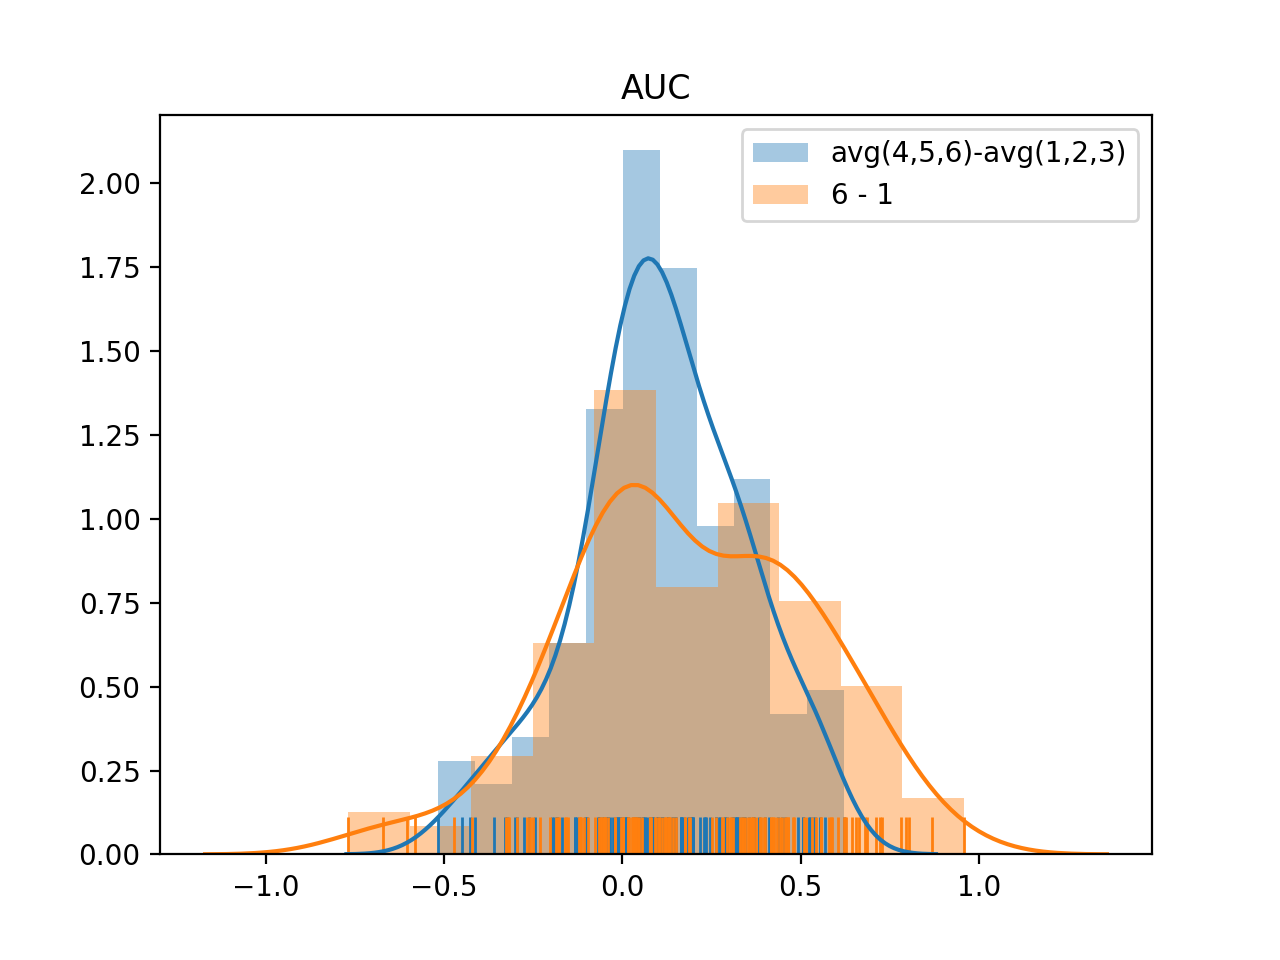

Skouras-Score score
Average difference between measures = 0.16380145205968166
skouras_learning measure has a variance of 0.3380568906533712
6-1 measure has a variance of 0.8905231804719707
Here is a random sample of 10 subjects.
     skouras_learning  six_minus_one  difference_between_measures
63          -1.161127      -0.317387                     0.843741
98           0.297772       0.116631                    -0.181141
10           0.374652       1.789481                     1.414829
23          -0.694217      -0.947552                    -0.253334
45           0.239878       0.284205                     0.044327
91          -0.403032       0.028610                     0.431642
87          -0.474010       0.051829                     0.525839
131         -0.145863       1.546726                     1.692589
17           0.183452      -0.581261                    -0.764713
32          -0.428604      -0.090367                     0.338237


<IPython.core.display.Javascript object>


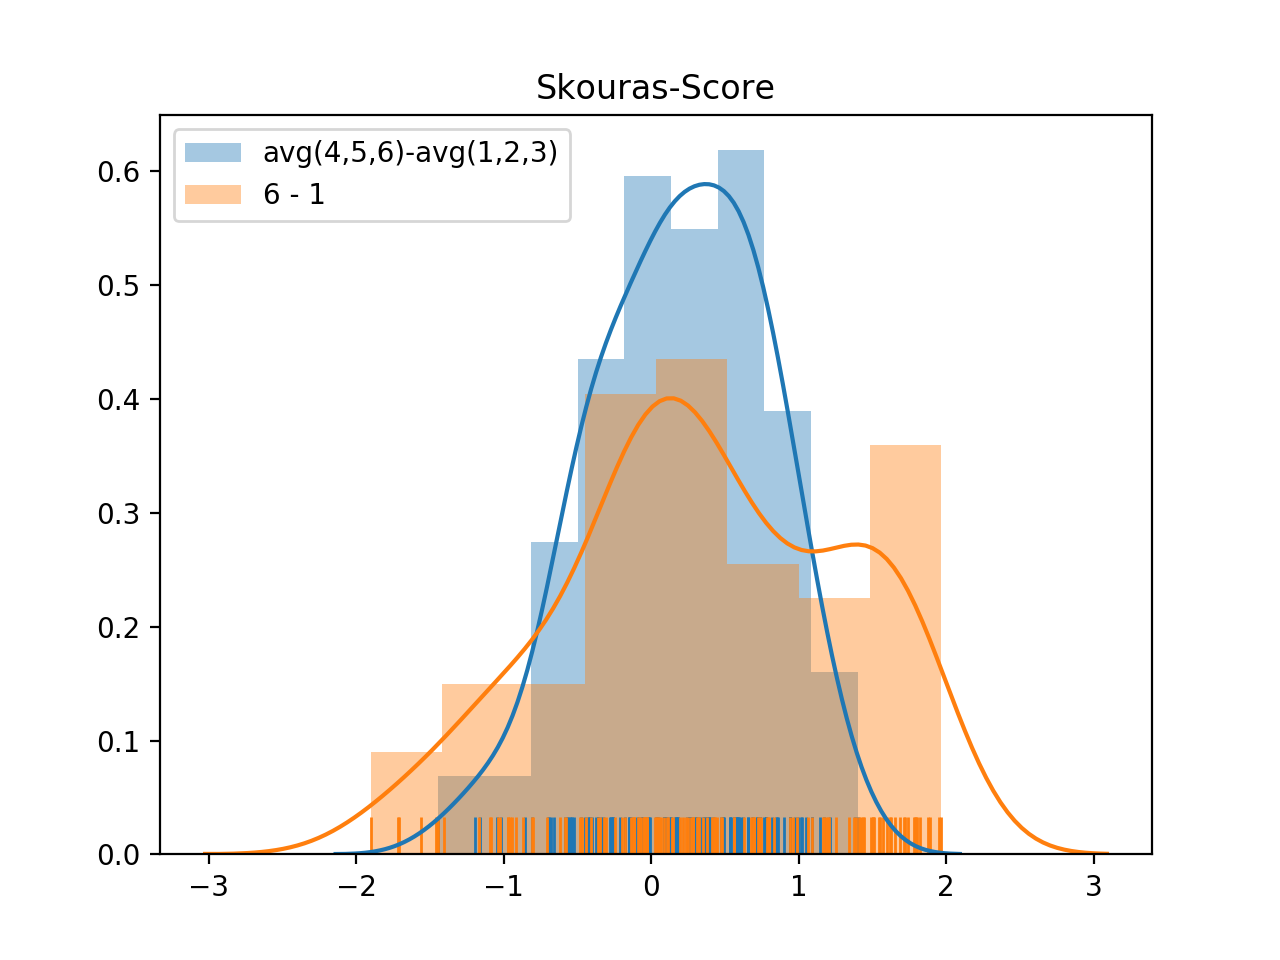

Time-to-peak score
Average difference between measures = -1.9927536231884058
skouras_learning measure has a variance of 66.47574039067423
6-1 measure has a variance of 459.1031821045999
Here is a random sample of 10 subjects.
     skouras_learning  six_minus_one  difference_between_measures
25           6.333333             -9                   -15.333333
51         -12.666667            -35                   -22.333333
22           2.333333             34                    31.666667
47          13.333333            -19                   -32.333333
56          -0.333333            -19                   -18.666667
70          12.000000             19                     7.000000
93           9.000000            -19                   -28.000000
50           8.000000             -2                   -10.000000
116          4.333333            -14                   -18.333333
11           1.333333              2                     0.666667


<IPython.core.display.Javascript object>


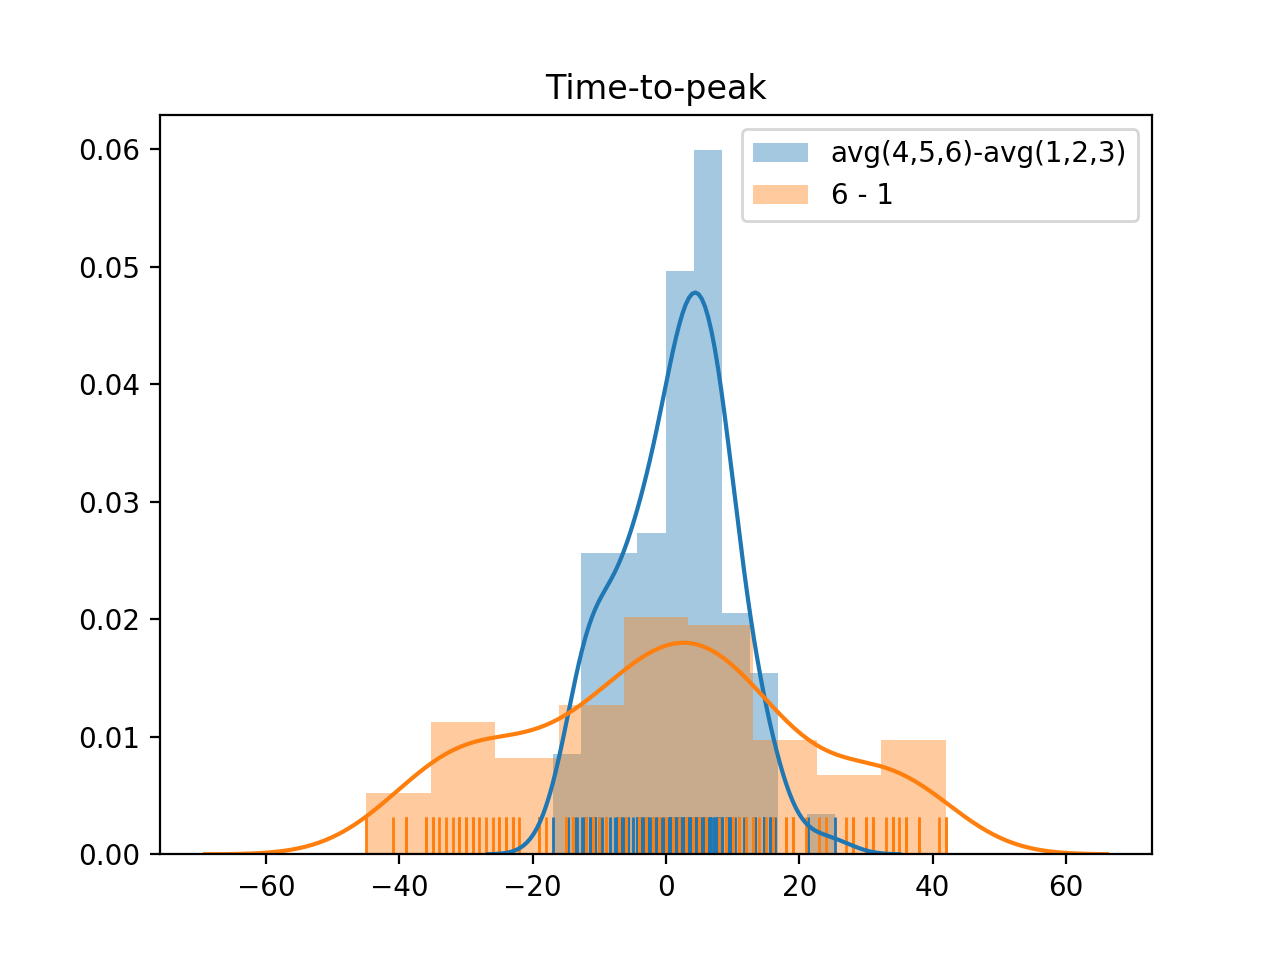

Peak score
Average difference between measures = 12.88526811594203
skouras_learning measure has a variance of 474.5868717101449
6-1 measure has a variance of 1478.3184356744907
Here is a random sample of 10 subjects.
     skouras_learning  six_minus_one  difference_between_measures
48          15.372000          0.269                   -15.103000
66          18.350667         88.728                    70.377333
75          25.389667         35.795                    10.405333
88          22.424000         50.082                    27.658000
14         -14.091667        -24.838                   -10.746333
99          -6.233000         29.838                    36.071000
124         14.155667         86.582                    72.426333
91           3.596667         -3.796                    -7.392667
20           9.444000          8.682                    -0.762000
64          14.934667         13.233                    -1.701667


<IPython.core.display.Javascript object>


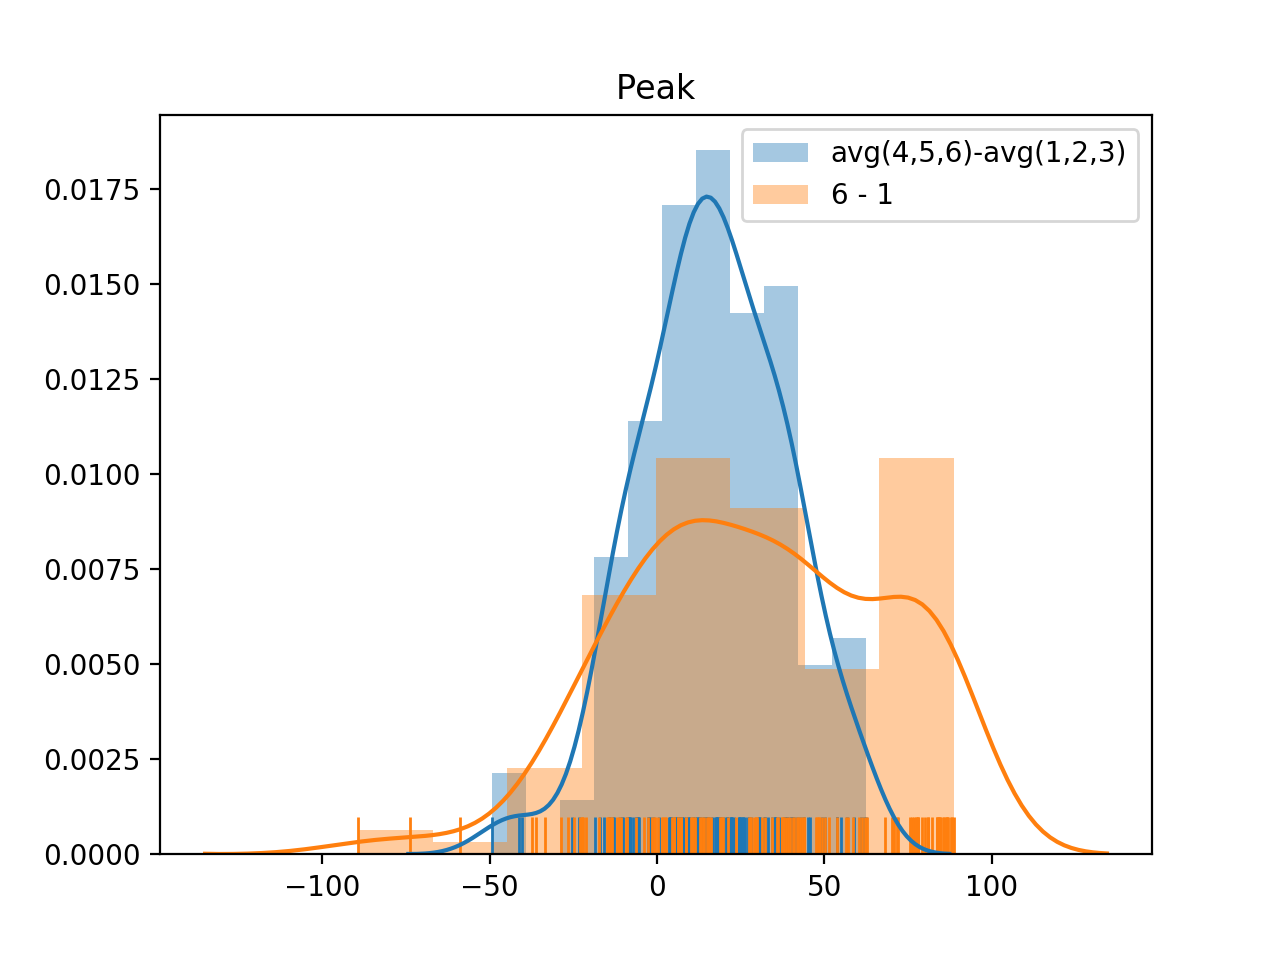

In [7]:
%matplotlib notebook
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

def learning_hist(series, title, dosample=False):
    if dosample:
        print(title, "score")
        print("Average difference between measures =", series['difference_between_measures'].mean(axis=0))
        print('skouras_learning measure has a variance of', np.var(series[['skouras_learning']].values))
        print('6-1 measure has a variance of', np.var(series[['six_minus_one']].values))
        print("Here is a random sample of 10 subjects.")
        print(series[['skouras_learning','six_minus_one', 'difference_between_measures']].sample(10))
    plt.figure()
    x = series[['skouras_learning']].values
    y = series[['six_minus_one']].values
    sns.distplot(x, kde=True, rug=True, label="avg(4,5,6)-avg(1,2,3)")
    sns.distplot(y, kde=True, rug=True, label="6 - 1")
    plt.legend()
    plt.title(title)
    plt.show()

aucdownserieslearning = add_learning_measures(aucdownseries)
skouradownserieslearning = add_learning_measures(skouradownseries)
ttpdownserieslearning = add_learning_measures(ttpdownseries)
peakdownserieslearning = add_learning_measures(peakdownseries)


learning_hist(aucdownserieslearning, "AUC", dosample=True)
learning_hist(skouradownserieslearning, "Skouras-Score", dosample=True)
learning_hist(ttpdownserieslearning, "Time-to-peak", dosample=True)
learning_hist(peakdownserieslearning, "Peak", dosample=True)

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 250em; }</style>"))

Reading in age and clinical status csv file made in pmetrics.ipynb.

Going to test for interesting correlations with them and the other data.

From skouras:
    In the control group, age (M = 30.71 years; SD = 7.48; nb = 62) correlated negatively with overall DMN NF performance score (M = 0.195, SD = 0.312) with a moderate association that explained 17% of the variance, r(62)=-0.412, R2 = 0.17, P = 0.0009; Fig. 3B.
    
My output:
    In the control group, age ( M = 32.05501195912154  years; SD = 7.8142617590016386 n = 63 ) correlated negatively with overall DMN NF performance score ( M = 0.19537175723329936 SD = 0.2955934924510536 ) with an association that explained 17.79582649049908 % of the variance, r(63) = -0.4218509984639017 R2 = 0.1779582649049908 P = 0.0005741932845391171
    
parameters that matter for correlations    
-whether I use first 30 secs or whole session

-type of scoring method

-type of score aggregation method (learning or overall)

-whether I remove sleepers

-which trials are considered in the aggregation


Also, it seems like the weirdness with n values is caused by how there are a few subjects we don't have ages for.

,ID,skouras_learning,NFB3_MRIQ_01,NFB3_MRIQ_02,AGE,AGE_04,SUB_TYPE,SUB_STUDY,DIAG_01#CODE,DIAG_01#DESC
0,A00028185,-0.055831,1.0,0.0,28.0,28.772603,ENROLLED,Neurofeedbac,305,Alcohol Abuse
1,A00032875,0.194524,1.0,1.0,40.0,40.852055,ENROLLED,LNG_ADULTFIT,300.29,Specific Phobia
2,A00033747,0.491988,1.0,0.0,27.0,27.926027,ENROLLED,Neurofeedbac,V71.09,No Diagnosis or Condition on Axis I
3,A00034854,0.366606,0.0,0.0,23.0,23.868493,ENROLLED,Neurofeedbac,296.2,"Major Depressive Disorder, Single Episode, Uns..."
4,A00035072,0.054367,0.0,0.0,38.0,38.435616,Adult- Age 22-59,Discoverysci,305,Alcohol Abuse
5,A00035827,0.163270,1.0,1.0,38.0,38.449315,ENROLLED,Neurofeedbac,V71.09,No Diagnosis or Condition on Axis I
6,A00035840,0.084985,0.0,0.0,26.0,26.739726,ENROLLED,Neurofeedbac,V71.09,No Diagnosis or Condition on Axis I
7,A00037112,-0.183244,1.0,0.0,36.0,36.830137,ENROLLED,Neurofeedbac,V71.09,No Diagnosis or Condition on Axis I
8,A00037511,0.009738,1.0,1.0,31.0,31.331507,ENROLLED,Neurofeedbac,303.9,Alcohol Dependence
9,A00037848,-0.052064,0.0,0.0,32.0,32.227397,Adult- Age 22-59,Discoverysci,296.36,"Major Depressive Disorder, Recurrent, In Full ..."


,ID,skouras_learning,NFB3_MRIQ_01,NFB3_MRIQ_02,AGE,AGE_04,SUB_TYPE,SUB_STUDY,DIAG_01#CODE,DIAG_01#DESC
18,A00043677,0.308944,NaN,NaN,25.0,25.923288,Adult- Age 22-59,Discoverysci,V71.09,No Diagnosis or Condition on Axis I
72,A00059428,0.622711,1.0,1.0,34.0,34.446575,NaN,NaN,NaN,NaN
94,A00061276,0.138505,NaN,NaN,37.0,37.093151,ONE_DAY- Age 22-59,Discoverysci,V71.09,No Diagnosis or Condition on Axis I
99,A00062210,0.127579,NaN,NaN,45.0,45.150685,ENROLLED,LNG_ADULTFIT,V71.09,No Diagnosis or Condition on Axis I
102,A00062282,0.399980,NaN,NaN,38.0,38.147945,ENROLLED,LNG_ADULTFIT,296.33,"Major Depressive Disorder, Recurrent, Severe W..."
105,A00062917,0.540870,NaN,NaN,24.0,24.336986,ONE_DAY- Age 22-59,Discoverysci,296.2,"Major Depressive Disorder, Single Episode, Uns..."


Lilliefors Test - Ages of all NFB Participants
n= 137 D = 0.11835174680868848 p= 0.0009999999999998899
Lilliefors Test - Ages of control-group NFB Participants
n= 63 D = 0.1275658428832686 p= 0.019659258894024714
Lilliefors Test - Ages of pathological NFB Participants
n= 74 D = 0.13388667825141093 p= 0.00423893638493488





Comparing ages of control-group with AUC Down overall score
Lilliefors Test AUC Down overall score
n= 63 D = 0.06483810798045175 p= 0.7764026343863832


<IPython.core.display.Javascript object>


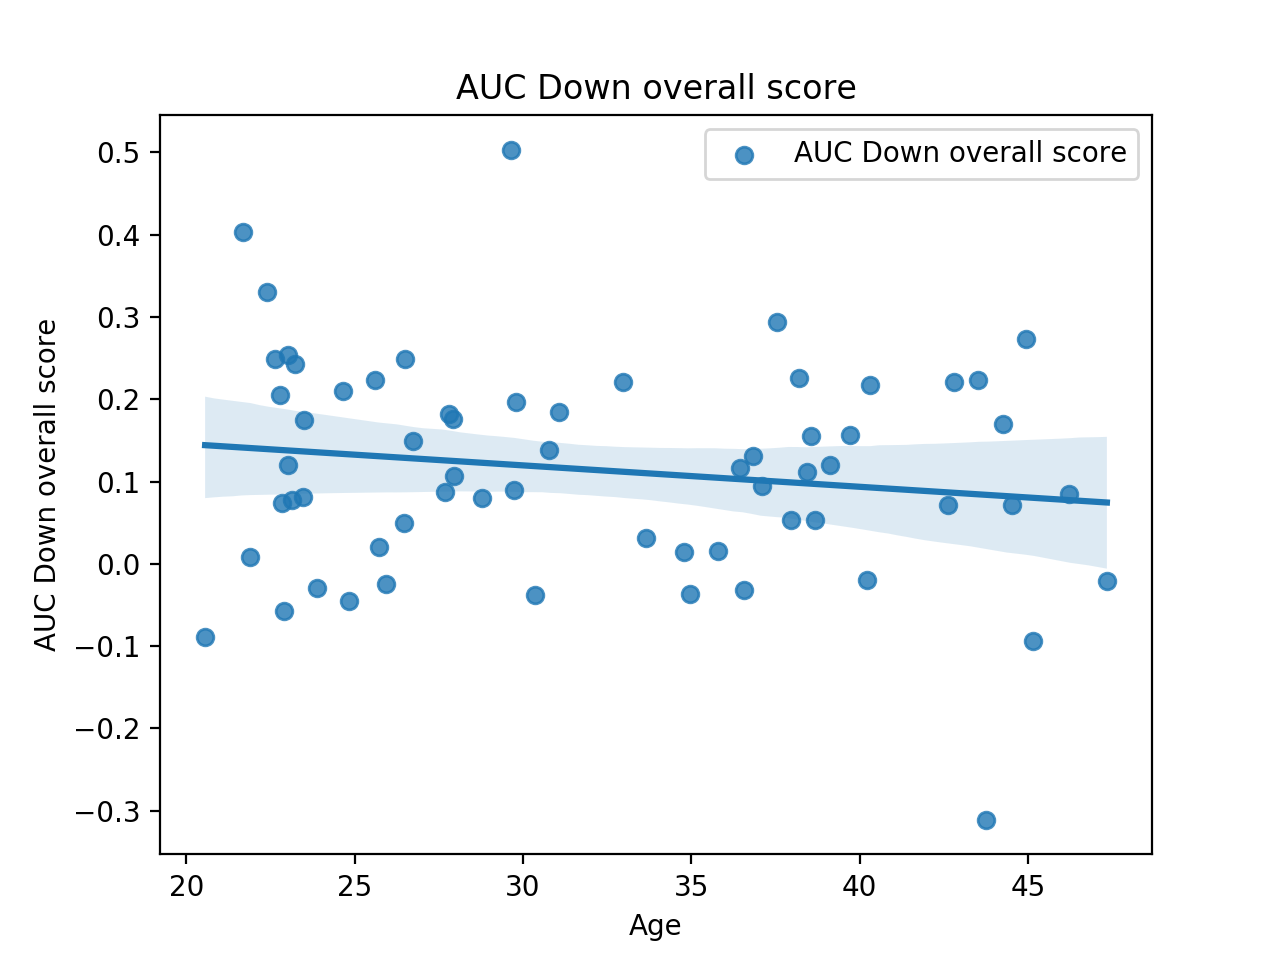

Correlation Tests AUC Down overall score (ran both, since I haven't figured out yet how to check for normal distribution)
Pearson r = -0.1573968964534114 R2 =  0.02477378301316591 p =  0.21795727143767887
Spearman r = -0.10138248847926268 R2 =  0.01027840897024783 p =  0.42916304095472846





Comparing ages of control-group with Skouras overall score
Lilliefors Test Skouras overall score
n= 63 D = 0.12723205885985173 p= 0.020137665091933037


<IPython.core.display.Javascript object>


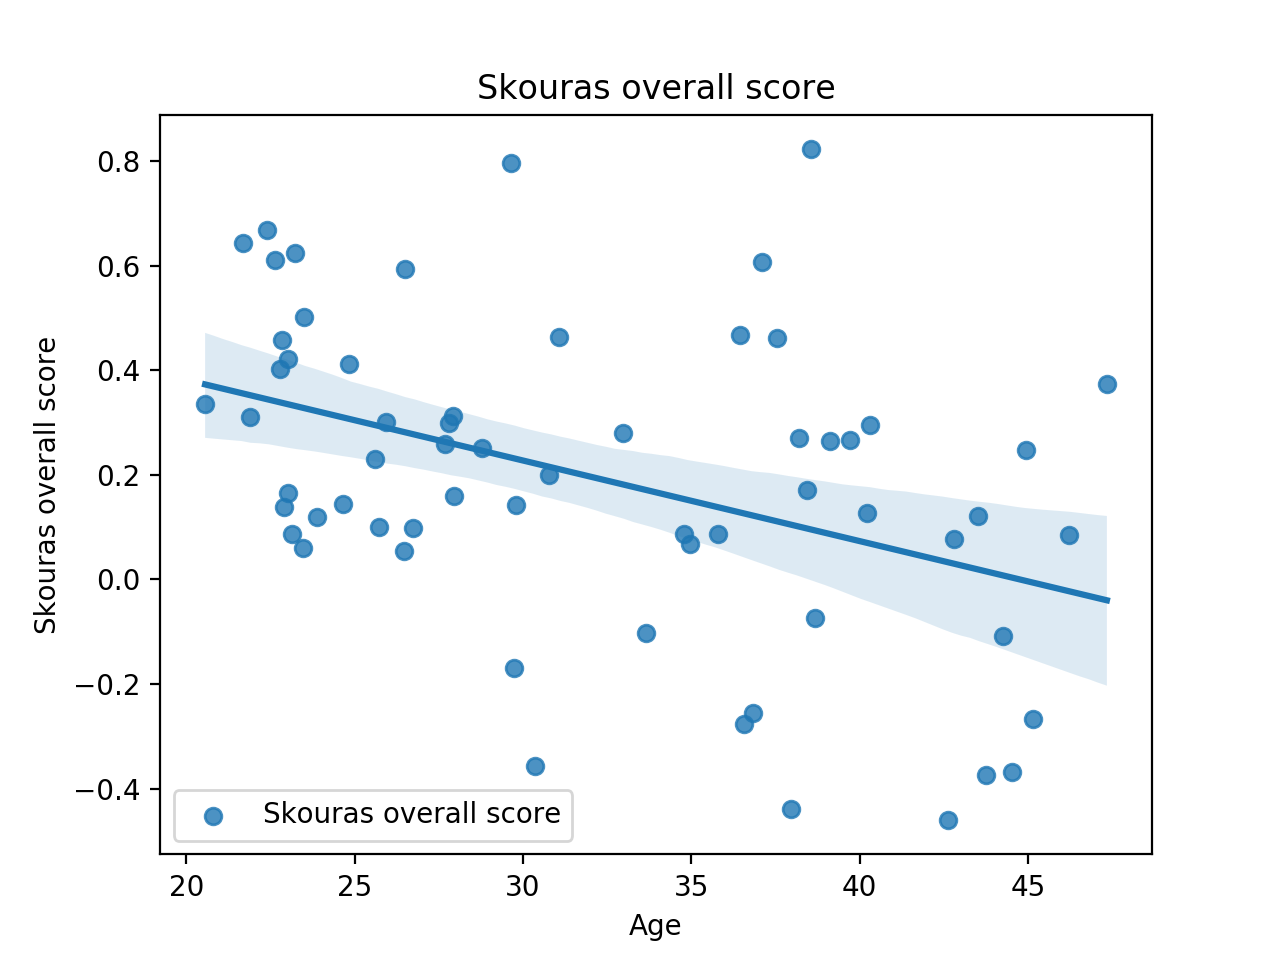

Correlation Tests Skouras overall score (ran both, since I haven't figured out yet how to check for normal distribution)
Pearson r = -0.41046190348097417 R2 =  0.16847897420922456 p =  0.0008340127618630023
Spearman r = -0.41887480798771126 R2 =  0.17545610476674198 p =  0.0006338283871352924





Comparing ages of control-group with AUC overall score
Lilliefors Test AUC overall score
n= 63 D = 0.1113335185508042 p= 0.06810228013624185


<IPython.core.display.Javascript object>


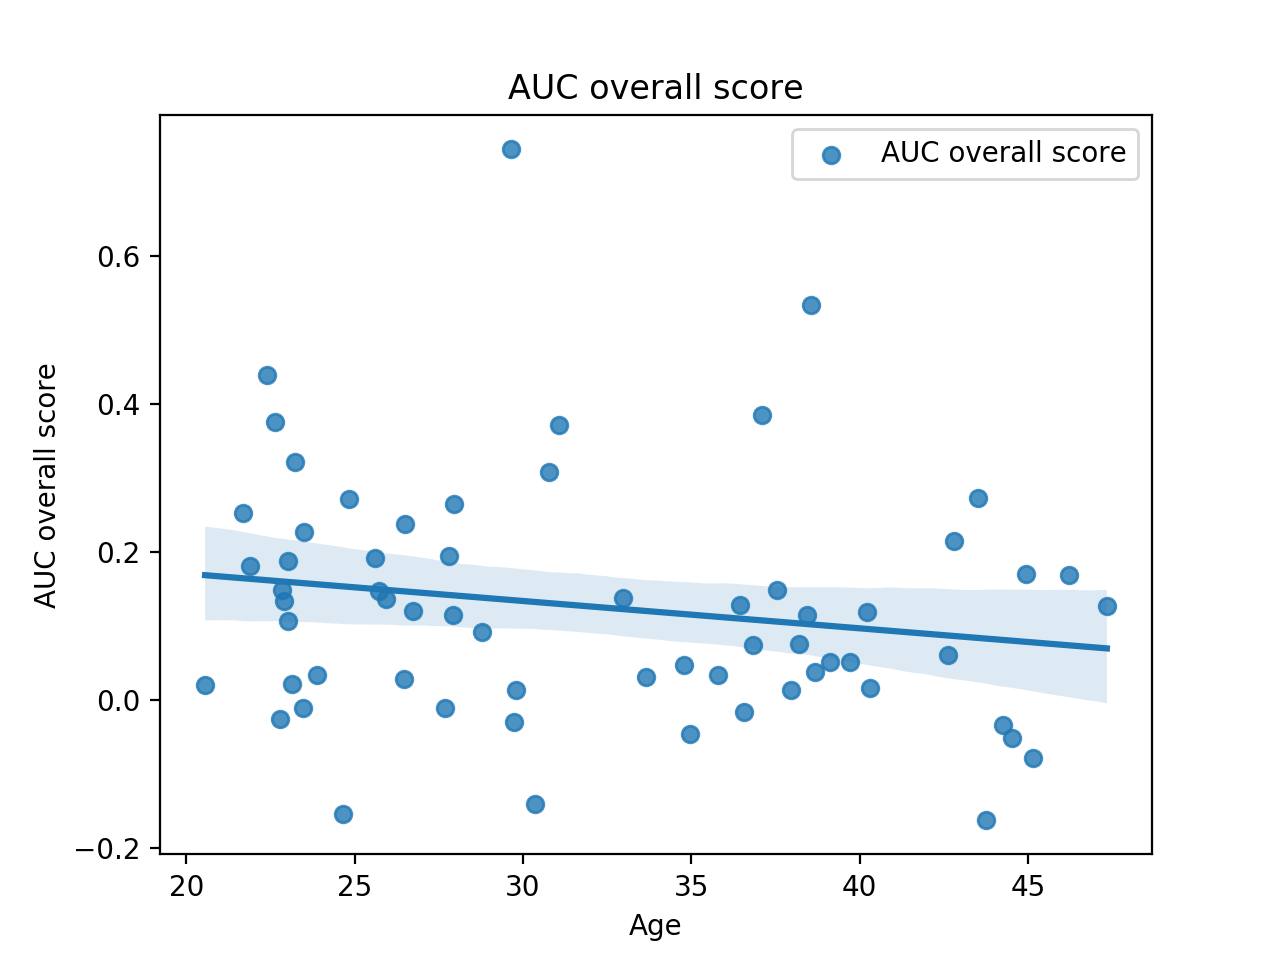

Correlation Tests AUC overall score (ran both, since I haven't figured out yet how to check for normal distribution)
Pearson r = -0.1804462306504721 R2 =  0.03256084215596338 p =  0.15700583761419554
Spearman r = -0.20804531490015363 R2 =  0.04328285305190409 p =  0.10179799973993064


In [13]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
from IPython.display import display, HTML
from scipy import stats
from scipy.stats import norm
from statsmodels.stats.diagnostic import lilliefors
import seaborn as sns

pd.set_option('display.max_rows', 300)

def lillie(nums, name=""):
    ksstat, pval = lilliefors(nums, pvalmethod='table')
    print("Lilliefors Test " + name)
    print("n=", len(nums), "D =", ksstat, "p=", pval)
    
def compare_with_age(othernums, vname="", path=False, exact=True, nosleep=True):
    diags_ages = pd.read_csv('./diags_ages.csv')
    diags_ages = pd.merge(skouraseries[['ID']], diags_ages, how='inner', on='ID').sort_values(by=['ID']).drop_duplicates(subset=['ID']).reset_index(drop=True)
    if nosleep:
        diags_ages = diags_ages[diags_ages['NFB3_MRIQ_01'] == 0].sort_values(by=['ID']).reset_index(drop=True)
    if not path:
        diags_ages_control = diags_ages[diags_ages['DIAG_01#CODE'] == 'V71.09'].sort_values(by=['ID']).reset_index(drop=True)
    else:
        diags_ages_control = diags_ages[diags_ages['DIAG_01#CODE'] != 'V71.09'].sort_values(by=['ID']).reset_index(drop=True)
    
    print("Comparing ages of control-group with " + vname)
    
    if exact:
        diags_ages_control = diags_ages_control[['ID', 'AGE_04']]
    else:
        diags_ages_control = diags_ages_control[['ID', 'AGE']]
    data = pd.merge(othernums, diags_ages_control, how='inner', on='ID').sort_values(by=['ID']).drop_duplicates(subset=['ID']).reset_index(drop=True)
    if exact:
        ages = data.AGE_04.values
    else:
        ages = data.AGE.values
    
    lillie(data[othernums.columns[1]].values, vname)
    
    pr, pp = stats.pearsonr(data[othernums.columns[1]].values, ages)
    sr, sp = stats.spearmanr(data[othernums.columns[1]].values, ages)
    
    x, y = pd.Series(ages, name="Age"), pd.Series(data[othernums.columns[1]].values, name=vname)
    plt.figure()
    ax = sns.regplot(x=x, y=y, label=vname)
    plt.legend()
    plt.title(vname)
    plt.show()
    
    print("Correlation Tests " + vname + " (ran both, since I haven't figured out yet how to check for normal distribution)")
    print("Pearson r =", pr, "R2 = ", pr ** 2, "p = ", pp)
    print("Spearman r =", sr, "R2 = ", sr ** 2, "p = ", sp)

    
#display(aucdownseries)
    
diags_ages = pd.read_csv('./diags_ages.csv')
diags_ages = pd.merge(aucdownseries[['ID', 'skouras_learning']], diags_ages, how='inner', on='ID').sort_values(by=['ID']).drop_duplicates(subset=['ID']).reset_index(drop=True)
display(diags_ages)
display(diags_ages[diags_ages.isna().any(axis=1)])


diags_ages_control = diags_ages[diags_ages['DIAG_01#CODE'] == 'V71.09'].sort_values(by=['ID']).reset_index(drop=True)
diags_ages_path = diags_ages[diags_ages['DIAG_01#CODE'] != 'V71.09'].sort_values(by=['ID']).reset_index(drop=True)

lillie(diags_ages.AGE_04.values, "- Ages of all NFB Participants")
lillie(diags_ages_control.AGE_04.values, "- Ages of control-group NFB Participants")
lillie(diags_ages_path.AGE_04.values, "- Ages of pathological NFB Participants")

print("\n\n\n\n")
trials = aucdownseries.loc[: , "1":"6"]
aucdownseries['scores'] = trials.mean(axis=1)
scores_only = aucdownseries[['ID', 'scores']]
compare_with_age(scores_only, "AUC Down overall score", nosleep=False)

print("\n\n\n\n")
trials = skouraseries.loc[: , "6":"12"]
skouraseries['scores'] = trials.mean(axis=1)
scores_only = skouraseries[['ID', 'scores']]
compare_with_age(scores_only, "Skouras overall score", nosleep=False)

print("\n\n\n\n")
trials = aucseries.loc[: , "7":"12"]
aucseries['scores'] = trials.mean(axis=1)
scores_only = aucseries[['ID', 'scores']]
compare_with_age(scores_only, "AUC overall score", nosleep=False)



